References:
    * https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec# 

## Load

In [19]:
import pandas as pd
data = pd.read_csv('dataset.tsv', sep='\t', index_col=0)

In [22]:
data.clean_text = data.clean_text.apply(eval)
data.bow = data.bow.apply(eval)
data.entities = data.entities.apply(eval)

## LDA features

In [23]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore

In [24]:
corpus = data.bow
dictionary = Dictionary(documents=data.clean_text.values)
print("Found {} words.".format(len(dictionary.values())))

Found 1882 words.


In [25]:
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [27]:
import numpy as np

In [28]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

In [ ]:
data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

In [29]:
X_lda = np.array(list(map(np.array, data.lda_features)))

## Clustering

In [30]:
K = len(data['intent'].unique())

In [31]:
X = X_lda
y = data['intent']

In [32]:
X.shape, y.shape

((3305, 150), (3305,))

---

In [36]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [37]:
from sklearn.mixture import GaussianMixture

In [38]:
km = KMeans(K).fit(X)

In [87]:
km = AgglomerativeClustering(K).fit(X)

In [93]:
km = GaussianMixture(K, tol=1e-6, max_iter=500).fit(X)

---

In [39]:
comp = pd.DataFrame(data[['text', 'intent']])

In [40]:
comp['clusters'] = km.predict(X)

In [41]:
comp['clusters'] = km.labels_

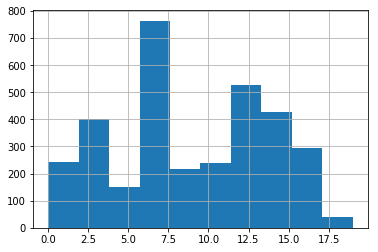

In [96]:
comp['clusters'].hist().get_figure().savefig('w2v/figure.pdf')

In [124]:
r = pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [125]:
r

In [39]:
from sklearn.metrics import *

In [40]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## GO

In [ ]:
raw_results = []
cms = []
np.random.seed(0)

for num_topics in [10, 20, 30, 50, 100, 150, 200, 300, 400, 500, 550, 600]:
    LDAmodel = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics,
                            workers=4,
                            chunksize=4000,
                            passes=7,
                            alpha='asymmetric')
    data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))
    X = np.array(list(map(np.array, data.lda_features)))
    print('%d features'%num_topics)
    for model in [KMeans, AgglomerativeClustering, GaussianMixture]:
        print('\t %s'%str(model).split('.')[-1][:-2])
        try:
            km = model(K, tol=1e-6, max_iter=500).fit(X)
        except:
            km = model(K).fit(X)


        comp = pd.DataFrame(data[['text', 'intent']])
        try:
            comp['clusters'] = km.labels_
        except:
            comp['clusters'] = km.predict(X)

        comp['clusters'].hist().get_figure().savefig('lda/hist_%d.pdf'%num_topics)
        cms += [pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
                    .style.background_gradient(axis=1)]
        raw_results += [(
            purity_score(comp['intent'], comp['clusters']),
            silhouette_score(X, comp['clusters']),
            homogeneity_score(comp['intent'], comp['clusters']),
            completeness_score(comp['intent'], comp['clusters']),
            num_topics,
            str(model).split('.')[-1][:-2])
        ]

10 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
20 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
30 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
50 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


100 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


150 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


200 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


300 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


400 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


500 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


550 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


600 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


In [42]:
results = pd.DataFrame(raw_results,
                       columns=['purity', 'silhouette', 'homogeneity', 
                                'completeness', 'features num', 'model'])


In [43]:
results['AVG'] = results[results.columns.difference(['model', 'features num'])].apply(np.mean, axis=1)

In [44]:
import seaborn as sns; sns.set()

In [45]:
results.style.background_gradient(axis=0)

,purity,silhouette,homogeneity,completeness,features num,model,AVG
0,0.25053,0.518061,0.158969,0.1784,10,KMeans,0.27649
1,0.269894,0.468171,0.167987,0.178809,20,KMeans,0.271216
2,0.25295,0.482884,0.16325,0.175902,30,KMeans,0.268746
3,0.271104,0.374711,0.171631,0.190485,50,KMeans,0.251983
4,0.249017,0.295354,0.149196,0.174522,100,KMeans,0.217022
5,0.265658,0.25384,0.172914,0.194664,150,KMeans,0.221769
6,0.264448,0.20049,0.166414,0.188866,200,KMeans,0.205054
7,0.268381,0.276394,0.175714,0.194357,300,KMeans,0.228712
8,0.267776,0.266948,0.171606,0.188755,400,KMeans,0.223771
9,0.268986,0.313255,0.193453,0.20406,500,KMeans,0.244939


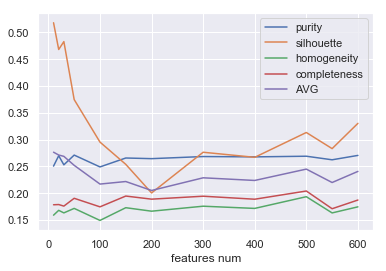

In [53]:
results.groupby('features num').mean().plot()

In [107]:
cms[9]

## Quick easy classifier

- 10 fold cross validation on 100 examples from labelled data
- Feed forward network
- Input = sequence of word representations

In [108]:
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=500,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')
data['lda_features'] = list(map(lambda doc:
                                  document_to_lda_features(LDAmodel, doc),
                                  data.bow))
X = np.array(list(map(np.array, data.lda_features)))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [200]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size=None, random_seed=42):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not sample_size:
        sample_size = round(min(uniq_counts.values()) * 0.8)
    
    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=False).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return data_train,labels_train

number of sampled example  1720 number of sample per class  86  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


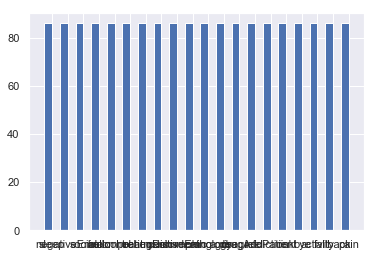

In [201]:
X_train,y_train=balanced_sample_maker(X,y)

In [202]:
pd.DataFrame([y_train.values, y_train.values]).T.groupby(0).count().sort_values(1).tail()

,1
0,
bye,86
alcohol,86
agree,86
social,86
treatment,86


In [203]:
y_train = y_train.fillna('hello')

In [204]:
bad_df = y.index.isin(y_train.index)
X_test = pd.DataFrame(X)[~bad_df]
y_test = data.loc[~bad_df]['intent']

In [205]:
from sklearn.svm import SVC

In [280]:
clf = SVC(kernel='linear', C=1, random_state=0, probability=True).fit(X_train, y_train)

In [281]:
clf.score(X_test, y_test)

0.3621451104100946

In [284]:
clf.predict(X_test[:40])

array(['risk', 'alcohol', 'alcohol', 'alcohol', 'alcohol',
       'eatingDisorders', 'pain', 'eatingDisorders', 'treatment',
       'alcohol', 'agree', 'alcohol', 'infoPatient', 'alcohol', 'alcohol',
       'hello', 'infoPatient', 'eatingDisorders', 'drugAddiction',
       'agree', 'agree', 'eatingDisorders', 'incomprehension',
       'eatingDisorders', 'drugAddiction', 'treatment', 'eatingDisorders',
       'incomprehension', 'agree', 'eatingDisorders', 'activity',
       'eatingDisorders', 'positiveEmo', 'risk', 'sleep', 'risk',
       'drugAddiction', 'risk', 'incomprehension', 'social'], dtype=object)

In [209]:
from sklearn.model_selection import cross_val_score

In [210]:
cv_scores = cross_val_score(clf, X_test, y_test, cv=10) 

In [211]:
cv_scores

array([0.44311377, 0.45783133, 0.51515152, 0.45398773, 0.41772152,
       0.43589744, 0.40909091, 0.45098039, 0.41447368, 0.41059603])

In [212]:
print('{:2.3} + {:2.3}%'.format(np.mean(cv_scores), np.std(cv_scores)))

0.441 + 0.0304%


In [213]:
from sklearn.metrics import confusion_matrix

In [214]:
clf_res = pd.DataFrame([clf.predict(X_test), y_test]).T
clf_res.columns = ['class', 'intent']

In [215]:
cm = pd.DataFrame(confusion_matrix(clf_res['intent'], clf_res['class']), 
             index=clf.classes_, columns=clf.classes_)

In [216]:
clf_res.groupby('class').count()

,intent
class,
activity,44
agree,194
alcohol,61
bye,41
disagree,9
drugAddiction,81
eatingDisorders,108
fallback,3
hello,123


In [217]:
clf_res.groupby('intent').count()

,class
intent,
activity,87
agree,24
alcohol,26
bye,24
disagree,23
drugAddiction,109
eatingDisorders,68
fallback,22
hello,24


In [219]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=1)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,17,10,2,2,0,1,7,0,7,9,0,1,1,2,5,2,5,0,4,12
agree,0,15,2,0,0,0,1,0,5,1,0,0,0,0,0,0,0,0,0,0
alcohol,0,1,10,0,0,0,3,0,1,1,3,0,1,0,0,2,1,0,0,3
bye,0,9,1,3,0,1,1,0,4,0,0,0,0,0,1,0,0,0,1,3
disagree,0,8,0,0,0,4,0,0,4,2,0,0,0,2,0,0,3,0,0,0
drugAddiction,4,2,5,4,0,25,2,1,6,14,2,1,3,4,1,15,5,4,3,8
eatingDisorders,3,12,1,0,0,5,24,0,1,10,0,0,1,1,1,2,2,0,2,3
fallback,0,11,0,0,0,2,1,1,2,0,0,1,0,0,0,0,4,0,0,0
hello,0,12,1,2,0,1,0,0,6,0,0,0,0,0,0,0,1,0,0,1
incomprehension,0,5,0,0,2,0,3,0,4,7,5,1,0,2,0,0,0,0,4,0


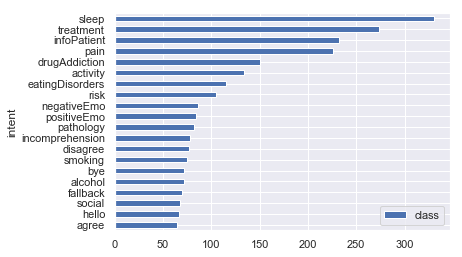

In [84]:
clf_res.groupby('intent').count().sort_values('class').plot(kind='barh')

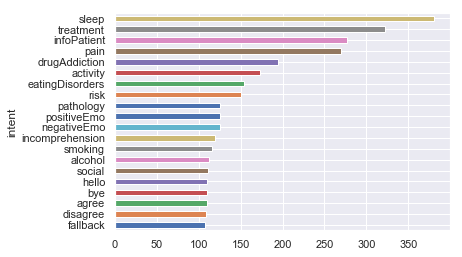

In [85]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

In [86]:
data.loc[0]

entities        [{'start': 34, 'end': 38, 'value': 'wine', 'en...
intent                                                    alcohol
text            I’m drinking at least a bottle of wine a day i...
clean_text               [drink, little, bottle, wine, day, week]
bow              [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
len                                                             6
lda_features    [0.009388589300215244, 0.008225347846746445, 0...
Name: 0, dtype: object

## Label new data

In [220]:
import json

In [253]:
posts = list(map(lambda x: x['post'], json.loads(open('subset.json', 'r').read())))[:100]

In [225]:
import spacy
nlp = spacy.blank('en')
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [226]:
import nltk,re

def get_good_tokens(sentence):
    stopwords = nltk.corpus.stopwords.words('english')+['pron']        
    
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z]+', '', token), sentence))
    replaced_numbers = list(map(lambda token: re.sub('[0-9]+', '_num_', token), replaced_punctation))
    removed_punctation = list(filter(lambda token: token, replaced_numbers))
    removed_stopwords = list(filter(lambda token: token not in stopwords, removed_punctation))
    return removed_stopwords

In [254]:
tokenized_posts = list(map(lambda post: 
                           list((get_good_tokens([token.text.lower() for token in sent]), sent)
                                for sent in nlp(post).sents), 
                    posts))

In [255]:
tokenized_posts = sum(tokenized_posts, [])

In [256]:
tokenized_posts[0]

(['divorce',
  'support',
  'group',
  'process',
  'divorced',
  'ca',
  'nt',
  'seem',
  'move'],
 How about a divorce support group for those who are in the process or have divorced and just can't seem to move on.)

In [259]:
new_data = pd.DataFrame(tokenized_posts, columns=['clean_text', 'text'])

In [265]:
new_data.text = new_data.text.apply(lambda x: ' '.join([word.text for word in x]))

In [267]:
new_data['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), new_data.clean_text))

In [270]:
new_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      new_data.bow))

In [271]:
new_data

,clean_text,text,bow,lda_features
0,"[divorce, support, group, process, divorced, c...",How about a divorce support group for those wh...,"[(135, 1), (256, 1), (1125, 1), (1259, 1), (13...","[0.43058520555496216, 0.14482085406780243, 0.0..."
1,"[know, divorced, _num_, years, ago, _num_, yea...",I know when I was divorced 6 years ago after 2...,"[(27, 2), (31, 1), (119, 1), (200, 1)]","[0.0023493359331041574, 0.0022487679962068796,..."
2,"[anyone, comments]",Anyone have any other comments ?,"[(1075, 1)]","[0.007048008032143116, 0.006746303755789995, 0..."
3,"[welcoming, suggestions, comments]",I 'm welcoming all suggestions and comments .,[],"[0.014096016064286232, 0.01349260751157999, 0...."
4,"[need, sound, advice]",I just need some sound advice .,"[(53, 1), (1392, 1)]","[0.33810386061668396, 0.004497535992413759, 0...."
5,"[dd, _num_]",I have a DD who is 2 .,"[(27, 1)]","[0.007048008032143116, 0.006746303755789995, 0..."
6,"[smart, tall, age, speaks, complete, sentences...","She is very smart , tall for her age , speak...","[(121, 1), (998, 1), (1087, 1)]","[0.003524004016071558, 0.0033731518778949976, ..."
7,"[appears, _num_, instead, turning, _num_]",She appears to be 3 instead of just turning 2 .,"[(27, 2), (137, 1)]","[0.0035240035504102707, 0.0033731514122337103,..."
8,"[goes, daycare, full, time]",She goes to daycare full - time .,"[(92, 1), (117, 1)]","[0.3423135280609131, 0.004497535992413759, 0.0..."
9,"[home, daycare, one, child, boy, andy, one, ye...",It 's an in - home daycare with only one oth...,"[(14, 1), (29, 1), (40, 1), (91, 2), (462, 1),...","[0.001762002008035779, 0.12753981351852417, 0...."


In [272]:
X_new_lda = np.array(list(map(np.array, new_data.lda_features)))

In [290]:
new_data['prediction'] = clf.predict(X_new_lda)
new_data['proba'] = clf.predict_proba(X_new_lda).max(axis=1)

In [310]:
pd.set_option('max_colwidth', 800)

In [312]:
new_data.sort_values('proba', ascending=False)[['text', 'proba', 'prediction', 'clean_text']]

,text,proba,prediction,clean_text
4667,\n\n Minouche \n I forgot to mention that I have been TTC for 4 years and that the ovulation / pregnancy test kits are not covered by the insurance nor spending account .,0.981843,smoking,"[minouche, forgot, mention, ttc, _num_, years, ovulation, pregnancy, test, kits, covered, insurance, spending, account]"
1690,"She was 4 when it took 8 months to diagnose , in an out of hospitals and test .",0.938715,smoking,"[_num_, took, _num_, months, diagnose, hospitals, test]"
4439,"I just had the test done on march 27 , 2001 .",0.938692,smoking,"[test, done, march, _num_, _num_]"
1446,"I take ultram(tramadol - generic ) for the pain , and it is not a narcotic , but is for osteoarthritis pain .",0.936798,pain,"[take, ultramtramadol, generic, pain, narcotic, osteoarthritis, pain]"
1519,And the pain is not in the places mentioned for Crohn 's .,0.933184,pain,"[pain, places, mentioned, crohn]"
4313,But the pain from ES is very similar to gall bladder .,0.933184,pain,"[pain, es, similar, gall, bladder]"
4090,After the surgery he had no pain .,0.933184,pain,"[surgery, pain]"
4454,and a deficiency of it will cause spasms ( that under the ribcage pain ) .,0.933184,pain,"[deficiency, cause, spasms, ribcage, pain]"
2363,Is she running to the bathroom alot or just in pain ?,0.933184,pain,"[running, bathroom, alot, pain]"
1518,It seems that my gas coincides with the pain .,0.933184,pain,"[seems, gas, coincides, pain]"


In [121]:
data.intent.unique()

array(['alcohol', 'eatingDisorders', 'pathology', 'drugAddiction',
       'smoking', 'treatment', 'sleep', 'infoPatient', 'pain', 'activity',
       'incomprehension', 'negativeEmo', 'positiveEmo', 'fallback',
       'social', 'agree', 'disagree', 'hello', 'bye', 'risk'],
      dtype=object)

In [302]:
new_data[new_data.prediction == 'sleep']\
    .sort_values('proba', ascending=False)[['text', 'proba', 'clean_text']]

,text,proba,clean_text
1163,He says that I might want to have corrective s...,0.665350,"[says, might, want, corrective, surgery, done]"
409,You want to argue about that .... your grounded .,0.665350,"[want, argue, grounded]"
3760,"\n\n\n I just want some relief , i feel desper...",0.606066,"[want, relief, feel, desperate]"
4473,\n\n [ This message has been edited by bluepum...,0.603509,"[message, edited, bluepumkin, edited, _num_, _..."
4216,\n\n [ This message has been edited by george7...,0.603509,"[message, edited, george_num_, edited, _num_, ..."
1240,\n\n [ This message has been edited by Breezee...,0.603506,"[message, edited, breezee, edited, _num_, _num..."
1213,\n\n [ This message has been edited by Dusty (...,0.603502,"[message, edited, dusty, edited, _num_, _num_,..."
4551,\n\n [ This message has been edited by EchoeB4...,0.603375,"[message, edited, echoeb_num_, edited, _num_, ..."
2106,\n\n [ This message has been edited by Harry (...,0.603347,"[message, edited, harry, edited, _num_, _num_,..."
868,\n < p>[This message has been edited by Tree F...,0.603294,"[pthis, message, edited, tree, frog, edited, _..."


In [314]:
new_data.loc[4216].text

'\n\n [ This message has been edited by george76 ( edited 01 - 14 - 2001 ) . ]'